In [317]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [318]:
import sys
sys.path.append("../")
import numpy as np
from itertools import product
from matplotlib import pyplot as plt
import seaborn as sns
from simulation import *

### Bivariate Normal Data Generation

In [302]:
from simulation import get_sampler, cls_to_dset, get_train_test_samples
MU = {
    0: [2, 2],
    1: [4, 1],
    2: [3, 5],
    3: [6, 3]
}
std = 0.2
COV = {
    0: np.eye(2)*std**2,
    1: np.eye(2)*std**2,
    2: np.eye(2)*std**2,
    3: np.eye(2)*std**2
}
K = 4
SAMPLERS = get_sampler(MU, COV, K)
# Get SAMPLES
n = 1000
X_TRAIN, Y_TRAIN, X_TEST, Y_TEST = get_train_test_samples(SAMPLERS=SAMPLERS, n=n)
# Dataset
IND_CLS = [0, 1, 2]
OOD_CLS = [3]
IND_DATA, IND_X, IND_Y = cls_to_dset(IND_CLS, X_TRAIN, Y_TRAIN)
OOD_DATA, OOD_X, OOD_Y = cls_to_dset(OOD_CLS, X_TRAIN, Y_TRAIN)
IND_DATA_TEST, IND_X_TEST, IND_Y_TEST = cls_to_dset(IND_CLS, X_TEST, Y_TEST)
OOD_DATA_TEST, OOD_X_TEST, OOD_Y_TEST = cls_to_dset(OOD_CLS, X_TEST, Y_TEST)

#### Plot

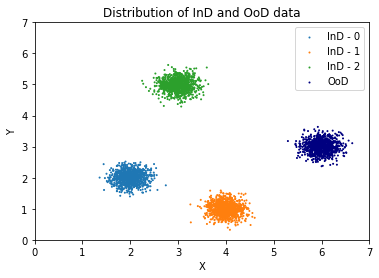

In [303]:
for idx in IND_CLS:
    plt.scatter(IND_X[:,0][IND_Y==idx], IND_X[:,1][IND_Y==idx], label =f"InD - {idx}", sizes=[1]*len(IND_X),alpha=1)
plt.scatter(OOD_X[:,0], OOD_X[:,1], c='navy', label ="OoD", sizes=[1]*len(OOD_X), alpha=1)
plt.xlim((0, 7))
plt.ylim((0, 7))
plt.legend()
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Distribution of InD and OoD data")
plt.show()

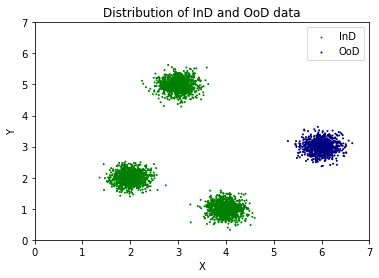

In [304]:
plt.scatter(IND_X[:,0], IND_X[:,1], c='green', label ="InD", sizes=[1]*len(IND_X),alpha=1)
plt.scatter(OOD_X[:,0], OOD_X[:,1], c='navy', label ="OoD", sizes=[1]*len(OOD_X), alpha=1)
plt.xlim((0, 7))
plt.ylim((0, 7))
plt.legend()
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Distribution of InD and OoD data")
plt.show()

### Naive Classifier Training

In [305]:
from tqdm import tqdm
from simulation import classifier_training
D = DSIM()
# Configuration
max_epoch = 100
lr = 1e-3
optimizer = torch.optim.Adam(D.parameters(), lr=lr, betas=(0.9, 0.999))
criterion = nn.CrossEntropyLoss()
# Dataset
ind_tri_loader = torch.utils.data.DataLoader(IND_DATA, shuffle=True, batch_size=256)
ind_val_loader = torch.utils.data.DataLoader(IND_DATA_TEST, shuffle=True, batch_size=256)
# Training
D = classifier_training(D, criterion, optimizer, ind_tri_loader, ind_val_loader, max_epoch, n_epoch=50)
torch.save(D.state_dict(), "simulation_log/model/D.pt")

  3%|▎         | 3/100 [00:00<00:07, 13.09it/s]

Epoch  # 1 | Tri loss: 1.0452                     | Tri accuracy: 0.3339
Epoch  # 1 | Val loss: 1.0279                     | Val accuracy: 0.3344


 54%|█████▍    | 54/100 [00:02<00:02, 21.32it/s]

Epoch  # 51 | Tri loss: 0.0502                     | Tri accuracy: 0.9997
Epoch  # 51 | Val loss: 0.0478                     | Val accuracy: 0.9997


100%|██████████| 100/100 [00:04<00:00, 20.72it/s]


#### Plot

torch.Size([10000, 3])


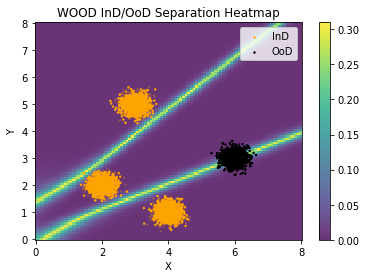

In [306]:
plot_wood = plot_heatmap(IND_X=IND_X, IND_X_TEST=IND_X_TEST, OOD_X=OOD_X, OOD_BATCH=OOD_X, 
                    D=D, method="WOOD", m=100)

### WOOD Training

In [324]:
from simulation import *
D_WOOD = DSIM(128)
# OOD data preparation
n_ood = 2
ood_bsz = 2
OOD_BATCH = torch.tensor(OOD_X[np.random.choice(n, n_ood, replace=False)], dtype=torch.float32)
torch.save(OOD_BATCH, "simulation_log/model/ood_batch.pt")
print(f"OOD Batch Shape: {OOD_BATCH.shape}")
# Configuration
max_epoch = 128
lr = 1e-3
beta = 0.1
optimizer = torch.optim.Adam(D_WOOD.parameters(), lr=lr, betas=(0.9, 0.999))
criterion = nn.CrossEntropyLoss()
# Dataset
ind_tri_loader = torch.utils.data.DataLoader(IND_DATA, shuffle=True, batch_size=256)
ind_val_loader = torch.utils.data.DataLoader(IND_DATA_TEST, shuffle=True, batch_size=256)
# Training
D_WOOD = wood_training(D_WOOD, OOD_BATCH, ood_bsz, beta, criterion, optimizer, ind_tri_loader, ind_val_loader, max_epoch, n_epoch=10)

OOD Batch Shape: torch.Size([2, 2])


  1%|          | 1/128 [00:00<00:47,  2.70it/s]

Epoch  # 1 | Tri loss: 0.9243                     | Tri accuracy: 0.6633
Epoch  # 1 | Val loss: 0.7778                     | Val accuracy: 0.7318


  9%|▊         | 11/128 [00:03<00:33,  3.49it/s]

Epoch  # 11 | Tri loss: 0.0837                     | Tri accuracy: 1.0
Epoch  # 11 | Val loss: 0.1026                     | Val accuracy: 1.0


 16%|█▋        | 21/128 [00:06<00:34,  3.06it/s]

Epoch  # 21 | Tri loss: -0.0007                     | Tri accuracy: 1.0
Epoch  # 21 | Val loss: 0.0326                     | Val accuracy: 1.0


 24%|██▍       | 31/128 [00:09<00:31,  3.08it/s]

Epoch  # 31 | Tri loss: -0.0178                     | Tri accuracy: 1.0
Epoch  # 31 | Val loss: 0.0167                     | Val accuracy: 1.0


 32%|███▏      | 41/128 [00:12<00:28,  3.05it/s]

Epoch  # 41 | Tri loss: -0.024                     | Tri accuracy: 1.0
Epoch  # 41 | Val loss: 0.0123                     | Val accuracy: 1.0


 40%|███▉      | 51/128 [00:15<00:22,  3.38it/s]

Epoch  # 51 | Tri loss: -0.0279                     | Tri accuracy: 1.0
Epoch  # 51 | Val loss: 0.007                     | Val accuracy: 1.0


 48%|████▊     | 61/128 [00:18<00:19,  3.45it/s]

Epoch  # 61 | Tri loss: -0.0329                     | Tri accuracy: 1.0
Epoch  # 61 | Val loss: 0.0042                     | Val accuracy: 1.0


 55%|█████▌    | 71/128 [00:22<00:22,  2.57it/s]

Epoch  # 71 | Tri loss: -0.0344                     | Tri accuracy: 1.0
Epoch  # 71 | Val loss: 0.003                     | Val accuracy: 1.0


 63%|██████▎   | 81/128 [00:26<00:19,  2.45it/s]

Epoch  # 81 | Tri loss: -0.0358                     | Tri accuracy: 1.0
Epoch  # 81 | Val loss: 0.0022                     | Val accuracy: 1.0


 71%|███████   | 91/128 [00:29<00:11,  3.18it/s]

Epoch  # 91 | Tri loss: -0.0339                     | Tri accuracy: 1.0
Epoch  # 91 | Val loss: 0.0019                     | Val accuracy: 1.0


 79%|███████▉  | 101/128 [00:33<00:12,  2.21it/s]

Epoch  # 101 | Tri loss: -0.0356                     | Tri accuracy: 1.0
Epoch  # 101 | Val loss: 0.0014                     | Val accuracy: 1.0


 87%|████████▋ | 111/128 [00:37<00:06,  2.66it/s]

Epoch  # 111 | Tri loss: -0.0364                     | Tri accuracy: 1.0
Epoch  # 111 | Val loss: 0.0011                     | Val accuracy: 1.0


 95%|█████████▍| 121/128 [00:41<00:02,  2.90it/s]

Epoch  # 121 | Tri loss: -0.0368                     | Tri accuracy: 1.0
Epoch  # 121 | Val loss: 0.0008                     | Val accuracy: 1.0


100%|██████████| 128/128 [00:43<00:00,  2.95it/s]


torch.Size([10000, 3])


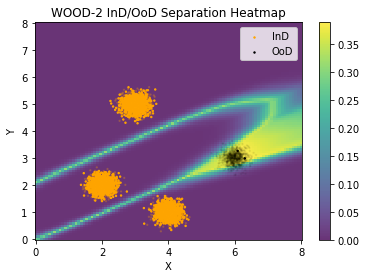

In [325]:
plot_wood = plot_heatmap(IND_X=IND_X, IND_X_TEST=IND_X_TEST, OOD_X=OOD_X, OOD_BATCH=OOD_BATCH, 
                    D=D_WOOD, method=f"WOOD-{n_ood}", m=100)

### OOD GAN Training

In [330]:
from simulation import *
D_GAN = DSIM(128)
G_GAN = GSIM(64)
# OOD data preparation
# n_ood = 64
ood_bsz = 16
bsz_tri = 64
# OOD_BATCH = torch.tensor(OOD_X[np.random.choice(n, n_ood, replace=False)], dtype=torch.float32)
print(f"OOD Batch Shape: {OOD_BATCH.shape}")
# Configuration
max_epoch = 64
lr = 1e-3
w_ce, w_wass, w_dist = 1, 0.01, 0.0
n_dim = 1
D_solver = torch.optim.Adam(D_GAN.parameters(), lr=lr, betas=(0.9, 0.999))
G_solver = torch.optim.Adam(G_GAN.parameters(), lr=lr, betas=(0.9, 0.999))
criterion = nn.CrossEntropyLoss()
# Dataset
ind_tri_loader = torch.utils.data.DataLoader(IND_DATA, shuffle=True, batch_size=256)
ind_val_loader = torch.utils.data.DataLoader(IND_DATA_TEST, shuffle=True, batch_size=256)
# Training
oodgan_training(D_GAN, G_GAN, D_solver, G_solver, OOD_BATCH, ood_bsz, bsz_tri, w_ce, w_wass, w_dist,\
                    ind_tri_loader, ind_val_loader, max_epoch, n_epoch=5, n_step_log=10)

OOD Batch Shape: torch.Size([2, 2])


  0%|          | 0/64 [00:00<?, ?it/s]

Step: 0    | D:  1.0611 | CE:  1.0610 | W_OoD:  0.9908 | W_z:  0.9607 | G:  0.0039 | W_z:  0.9536 | dist: 4.8178
Step: 10   | D:  0.8366 | CE:  0.8363 | W_OoD:  1.0371 | W_z:  0.9395 | G:  0.0039 | W_z:  0.9434 | dist: 4.9797


  2%|▏         | 1/64 [00:22<24:00, 22.86s/it]

Epoch  # 1 | Val accuracy: 0.6668
Step: 8    | D:  0.7055 | CE:  0.7053 | W_OoD:  1.0120 | W_z:  0.9432 | G:  0.0039 | W_z:  0.9420 | dist: 4.9624


  3%|▎         | 2/64 [00:45<23:22, 22.61s/it]

Step: 6    | D:  0.6602 | CE:  0.6600 | W_OoD:  0.9944 | W_z:  0.9383 | G:  0.0039 | W_z:  0.9399 | dist: 4.8580


  5%|▍         | 3/64 [01:06<22:24, 22.04s/it]

Step: 4    | D:  0.6223 | CE:  0.6221 | W_OoD:  1.0032 | W_z:  0.9477 | G:  0.0039 | W_z:  0.9481 | dist: 4.5440


  6%|▋         | 4/64 [01:29<22:17, 22.29s/it]

Step: 2    | D:  0.6151 | CE:  0.6149 | W_OoD:  1.0057 | W_z:  0.9383 | G:  0.0039 | W_z:  0.9420 | dist: 4.3282


  8%|▊         | 5/64 [01:51<21:43, 22.09s/it]

Step: 0    | D:  0.6234 | CE:  0.6229 | W_OoD:  1.0910 | W_z:  0.9468 | G:  0.0039 | W_z:  0.9470 | dist: 3.4423
Step: 10   | D:  0.7201 | CE:  0.7199 | W_OoD:  1.0171 | W_z:  0.9442 | G:  0.0039 | W_z:  0.9475 | dist: 2.7230


  9%|▉         | 6/64 [02:14<21:45, 22.50s/it]

Epoch  # 6 | Val accuracy: 0.8685
Step: 8    | D:  0.7111 | CE:  0.7109 | W_OoD:  1.0053 | W_z:  0.9442 | G:  0.0038 | W_z:  0.9628 | dist: 2.2134


 11%|█         | 7/64 [02:35<20:54, 22.00s/it]

Step: 6    | D:  0.6742 | CE:  0.6741 | W_OoD:  0.9925 | W_z:  0.9566 | G:  0.0039 | W_z:  0.9433 | dist: 2.3098


 12%|█▎        | 8/64 [02:57<20:29, 21.96s/it]

Step: 4    | D:  0.5916 | CE:  0.5911 | W_OoD:  1.0721 | W_z:  0.9452 | G:  0.0039 | W_z:  0.9458 | dist: 2.8661


 14%|█▍        | 9/64 [03:18<19:56, 21.76s/it]

Step: 2    | D:  0.6944 | CE:  0.6935 | W_OoD:  1.2063 | W_z:  0.9431 | G:  0.0039 | W_z:  0.9417 | dist: 3.3174


 16%|█▌        | 10/64 [03:39<19:24, 21.57s/it]

Step: 0    | D:  0.9960 | CE:  0.9946 | W_OoD:  1.3855 | W_z:  0.9636 | G:  0.0039 | W_z:  0.9542 | dist: 3.7796
Step: 10   | D:  1.0288 | CE:  1.0280 | W_OoD:  1.2078 | W_z:  0.9693 | G:  0.0038 | W_z:  0.9588 | dist: 4.3253


 17%|█▋        | 11/64 [04:00<18:50, 21.33s/it]

Epoch  # 11 | Val accuracy: 0.3327
Step: 8    | D:  1.0687 | CE:  1.0679 | W_OoD:  1.2014 | W_z:  0.9502 | G:  0.0039 | W_z:  0.9420 | dist: 4.6655


 19%|█▉        | 12/64 [04:21<18:30, 21.36s/it]

Step: 6    | D:  1.0494 | CE:  1.0486 | W_OoD:  1.1988 | W_z:  0.9514 | G:  0.0039 | W_z:  0.9525 | dist: 4.7308


 20%|██        | 13/64 [04:43<18:12, 21.43s/it]

Step: 4    | D:  0.9656 | CE:  0.9646 | W_OoD:  1.2615 | W_z:  0.9607 | G:  0.0039 | W_z:  0.9512 | dist: 4.7768


 22%|██▏       | 14/64 [05:04<17:51, 21.43s/it]

Step: 2    | D:  0.9613 | CE:  0.9605 | W_OoD:  1.1949 | W_z:  0.9473 | G:  0.0039 | W_z:  0.9429 | dist: 4.7384


 23%|██▎       | 15/64 [05:27<17:52, 21.89s/it]

Step: 0    | D:  0.8941 | CE:  0.8932 | W_OoD:  1.1897 | W_z:  0.9392 | G:  0.0039 | W_z:  0.9374 | dist: 4.7477
Step: 10   | D:  0.8103 | CE:  0.8094 | W_OoD:  1.1995 | W_z:  0.9368 | G:  0.0039 | W_z:  0.9392 | dist: 4.7474


 25%|██▌       | 16/64 [05:51<17:50, 22.30s/it]

Epoch  # 16 | Val accuracy: 0.3339
Step: 8    | D:  0.8088 | CE:  0.8080 | W_OoD:  1.1746 | W_z:  0.9406 | G:  0.0039 | W_z:  0.9364 | dist: 4.7529


 27%|██▋       | 17/64 [06:12<17:16, 22.06s/it]

Step: 6    | D:  0.7205 | CE:  0.7197 | W_OoD:  1.1634 | W_z:  0.9388 | G:  0.0039 | W_z:  0.9428 | dist: 4.7617


 28%|██▊       | 18/64 [06:35<17:11, 22.42s/it]

Step: 4    | D:  0.7679 | CE:  0.7672 | W_OoD:  1.1475 | W_z:  0.9378 | G:  0.0039 | W_z:  0.9362 | dist: 4.7777


 30%|██▉       | 19/64 [06:57<16:44, 22.31s/it]

Step: 2    | D:  0.7571 | CE:  0.7564 | W_OoD:  1.1230 | W_z:  0.9366 | G:  0.0039 | W_z:  0.9370 | dist: 4.7596


 31%|███▏      | 20/64 [07:21<16:34, 22.59s/it]

Step: 0    | D:  0.6842 | CE:  0.6837 | W_OoD:  1.0726 | W_z:  0.9362 | G:  0.0039 | W_z:  0.9351 | dist: 4.7468
Step: 10   | D:  0.6273 | CE:  0.6270 | W_OoD:  1.0178 | W_z:  0.9354 | G:  0.0039 | W_z:  0.9373 | dist: 4.7457


 33%|███▎      | 21/64 [07:44<16:21, 22.82s/it]

Epoch  # 21 | Val accuracy: 0.9167
Step: 8    | D:  0.6132 | CE:  0.6130 | W_OoD:  0.9851 | W_z:  0.9398 | G:  0.0039 | W_z:  0.9372 | dist: 4.7289


 34%|███▍      | 22/64 [08:06<15:41, 22.42s/it]

Step: 6    | D:  0.6082 | CE:  0.6081 | W_OoD:  0.9869 | W_z:  0.9378 | G:  0.0039 | W_z:  0.9377 | dist: 4.7261


 36%|███▌      | 23/64 [08:27<15:09, 22.18s/it]

Step: 4    | D:  0.6549 | CE:  0.6548 | W_OoD:  0.9766 | W_z:  0.9363 | G:  0.0039 | W_z:  0.9358 | dist: 4.7391


 38%|███▊      | 24/64 [08:52<15:18, 22.96s/it]

Step: 2    | D:  0.5674 | CE:  0.5673 | W_OoD:  0.9731 | W_z:  0.9349 | G:  0.0039 | W_z:  0.9368 | dist: 4.7558


 39%|███▉      | 25/64 [09:16<15:07, 23.28s/it]

Step: 0    | D:  0.6102 | CE:  0.6101 | W_OoD:  0.9741 | W_z:  0.9390 | G:  0.0039 | W_z:  0.9370 | dist: 4.7514
Step: 10   | D:  0.5600 | CE:  0.5598 | W_OoD:  0.9688 | W_z:  0.9355 | G:  0.0039 | W_z:  0.9371 | dist: 4.7390


 41%|████      | 26/64 [09:40<14:51, 23.46s/it]

Epoch  # 26 | Val accuracy: 0.966
Step: 8    | D:  0.5718 | CE:  0.5717 | W_OoD:  0.9706 | W_z:  0.9366 | G:  0.0039 | W_z:  0.9371 | dist: 4.7257


 42%|████▏     | 27/64 [10:05<14:46, 23.96s/it]

Step: 6    | D:  0.5953 | CE:  0.5951 | W_OoD:  0.9792 | W_z:  0.9359 | G:  0.0039 | W_z:  0.9364 | dist: 4.7410


 44%|████▍     | 28/64 [10:29<14:27, 24.09s/it]

Step: 4    | D:  0.5806 | CE:  0.5805 | W_OoD:  0.9696 | W_z:  0.9348 | G:  0.0039 | W_z:  0.9353 | dist: 4.7449


 45%|████▌     | 29/64 [10:54<14:13, 24.38s/it]

Step: 2    | D:  0.5251 | CE:  0.5249 | W_OoD:  0.9734 | W_z:  0.9345 | G:  0.0039 | W_z:  0.9354 | dist: 4.7241


torch.Size([10000, 3])


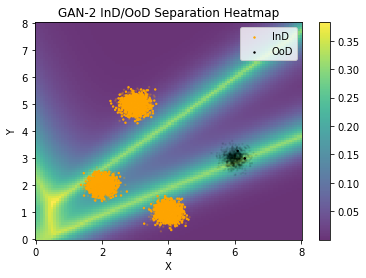

In [328]:
from simulation import plot_heatmap
plot = plot_heatmap(IND_X=IND_X, IND_X_TEST=IND_X_TEST, OOD_X=OOD_X, OOD_BATCH=OOD_BATCH, 
                    D=D_GAN, method=f"GAN-{n_ood}", m=100)

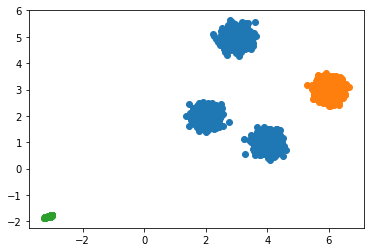

In [329]:
seed = torch.rand((128, 1))
gz = G_GAN(seed).detach().numpy()
plt.scatter(IND_X[:,0], IND_X[:,1])
plt.scatter(OOD_X[:,0], OOD_X[:,1])
plt.scatter(gz[:,0], gz[:,1])
plt.show()

In [299]:
from simulation import calculate_accuracy
calculate_accuracy(D=D, ind=IND_X, ood=OOD_X, tnr=0.95)

torch.Size([300, 3])
torch.Size([300])
0.00822144187986851
torch.Size([100, 3])
tensor(0.7200)


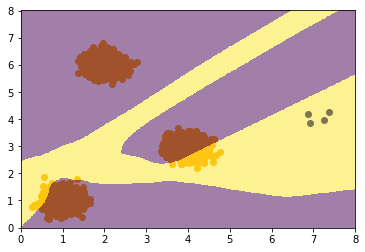

In [90]:
plt.scatter(IND_X[:,0], IND_X[:,1], c='orange', label ="InD", alpha=1)
# plt.scatter(OOD_X[:,0], OOD_X[:,1], c='navy', label="OoD", alpha=0.05)
plt.scatter(OOD_BATCH[:,0], OOD_BATCH[:,1], c='navy', label="OoD", alpha=1)
plt.pcolormesh(xi, yi, mask.reshape((m, m)).T, shading='auto', alpha=0.5)

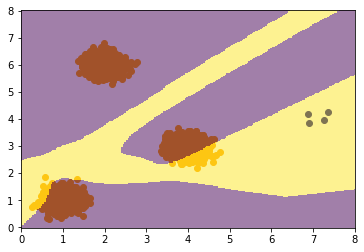

In [88]:
plt.scatter(IND_X[:,0], IND_X[:,1], c='orange', label ="InD", alpha=1)
# plt.scatter(OOD_X[:,0], OOD_X[:,1], c='navy', label="OoD", alpha=0.05)
plt.scatter(OOD_BATCH[:,0], OOD_BATCH[:,1], c='navy', label="OoD", alpha=1)
plt.pcolormesh(xi, yi, mask.reshape((m, m)).T, shading='auto', alpha=0.5)